In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

Torch

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Utils

In [3]:
def read_header_and_data(file_path, idx):
    with fits.open(file_path) as hdu:
        header = hdu[idx].header
        data = hdu[idx].data

        return header, data

def show_image(image_data, cmap='gist_gray'):
    plt.figure()
    plt.imshow(image_data.permute(1, 2, 0), cmap=cmap) # [batch_size, height, width, channels]
    plt.colorbar()

def mean_subtract(img_data):
    img_mean = np.mean(img_data)
    img_data -= img_mean

    return img_data

def normalize(array):
    arr_max = np.max(array)
    arr_min = np.min(array)

    arr_normalized = (array - arr_min) / (arr_max - arr_min)

    return arr_normalized

def normalize_list(list_arrays):
    list_arrays_normalized = []
    list_arrays_normalized += [normalize(array) for array in list_arrays]
    list_arrays_normalized = np.array(list_arrays_normalized)

    return list_arrays_normalized

def convert_dataset_to_tensor(dataset):
    new_dataset = []
    for el in dataset:
        n_el = torch.from_numpy(el)
        n_el = n_el.permute(2, 0, 1) # [batch_size, channels, height, width]
        new_dataset.append(n_el)
    new_dataset_tensor = torch.stack(new_dataset)

    return new_dataset_tensor



ResUNet (denoising)

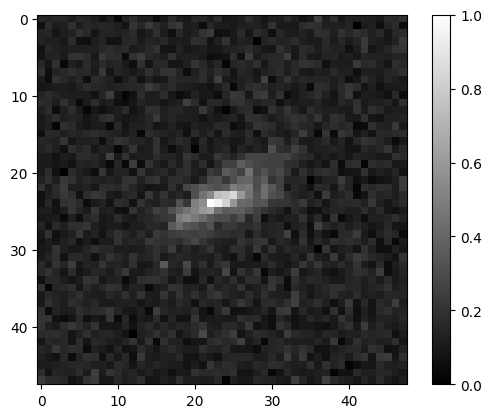

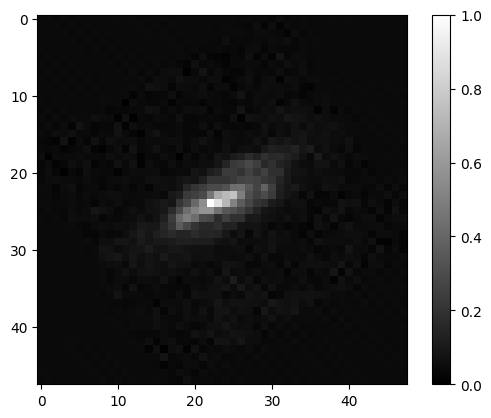

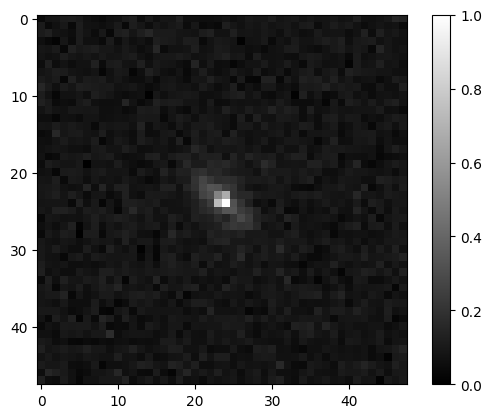

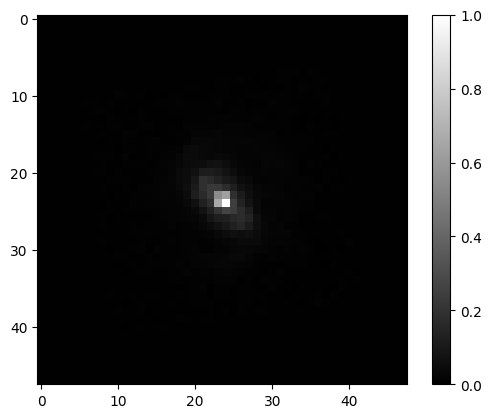

In [4]:
image_file_path = 'outputs/output_denoising_snr100.fits'
img_head, img_data = read_header_and_data(image_file_path, 0)

#img_data = np.random.permutation(img_data)
img_data = normalize_list(img_data)
img_size = img_data[0].shape[0]
num_total = len(img_data)
train_split = 0.7
train_idx = int(num_total * train_split)

img_data = np.array([np.reshape(img, (img_size, img_size, 1)) for img in img_data])
img_shape = img_data[0].shape

# Convert dataset to torch tensor
img_data = convert_dataset_to_tensor(img_data)

# Spliting training and testing
train = img_data[0:train_idx]
train_x = train[[i for i in range(0, len(train), 2)]]
train_y = train[[i for i in range(1, len(train), 2)]]

test = img_data[train_idx:num_total]
test_x = test[[i for i in range(0, len(test), 2)]]
test_y = test[[i for i in range(1, len(test), 2)]]

idx = 0
show_image(train_x[idx])
show_image(train_y[idx])
show_image(test_x[idx])
show_image(test_y[idx])

In [5]:
print(test_x.size())

torch.Size([3000, 1, 48, 48])


In [7]:
# from paper Qian, H. et al 2022

class ResUNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, x_shortcut) -> None:
        super().__init__()
        self.x_shortcut = x_shortcut
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
    
    def forward(self, x):
        rb = nn.Conv2d(x.size(1), self.out_channels, self.kernel_size, padding='same')(x)
        rb = nn.BatchNorm2d(self.out_channels)(rb)
        rb = nn.ReLU()(rb)
        rb = nn.Conv2d(self.out_channels, self.out_channels, self.kernel_size, padding='same')(rb)
        
        self.x_shortcut = nn.Conv2d(self.x_shortcut.size(1), self.out_channels, kernel_size=1, padding='same')(self.x_shortcut)

        return rb + self.x_shortcut

class UpsampleConcatenate(nn.Module):
    def __init__(self, skip) -> None:
        super().__init__()
        self.skip = skip
    
    def forward(self, x):
        x = nn.Upsample(scale_factor=2)(x)

        return torch.cat([x, self.skip], dim=1) 


class ResUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=64, kernel_size=3, num_resunet_blocks=4) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.num_resunet_blocks = num_resunet_blocks

        self.relu = nn.ReLU()

        self.transition = nn.Sequential(
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.Conv2d(self.out_channels, self.out_channels * 2, self.kernel_size, padding='same'),
            nn.BatchNorm2d(self.out_channels*2),
            nn.ReLU(),
            nn.Conv2d(self.out_channels * 2, self.out_channels * 2, self.kernel_size, padding='same')
        )
    
    def forward(self, x):
        # Encoder
        skip_stack = []
        for i in range(self.num_resunet_blocks):
            #print(f"enc {i} {x.size()}")
            if not i == 0: x = nn.BatchNorm2d(x.size(1))(x)
            x = ResUNetBlock(self.in_channels, self.out_channels, self.kernel_size, x)(x)
            if not i == self.num_resunet_blocks-1:
                skip_stack += [x] # copy
                x = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=2, stride=2)(x)
        
        # Transition
        #print(f"tr x.size()")
        x = self.transition(x)
                
        # Decoder
        for i in range(len(skip_stack)):
            #print(f"dec {i} {x.size()}")
            skip = skip_stack.pop()
            x = UpsampleConcatenate(skip)(x)
            x_shortcut = x
            x = nn.BatchNorm2d(x.size(1))(x)
            x = self.relu(x)
            x = ResUNetBlock(self.in_channels, self.out_channels, self.kernel_size, x_shortcut)(x)
        
        # Output
        #print("out")
        x = nn.BatchNorm2d(x.size(1))(x)
        x = nn.Conv2d(x.size(1), 1, self.kernel_size, padding='same')(x)
        x = nn.Sigmoid()(x)
        
        return x

In [8]:
resunet = ResUNet().to(device)
print(resunet)

ResUNet(
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (transition): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
)


In [6]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.conv_input = nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, padding='same')
        self.bn = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(self.out_channels, self.out_channels, self.kernel_size, padding='same')
    
    def forward(self, x):
        rb = self.conv_input(x)
        rb = self.bn(rb)
        rb = self.relu(rb)
        rb = self.conv1(rb)
    
        return rb + x

class UpsampleConcatenate(nn.Module):
    def __init__(self, skip) -> None:
        super().__init__()
        self.skip = skip
        self.upsample = nn.Upsample(scale_factor=2)
    
    def forward(self, x):
        x = self.upsample(x)

        return torch.cat([x, self.skip], dim=1)

class ResUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=64, kernel_size=3) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.skip = None
        
        # Encode
        self.resnetblock1 = ResNetBlock(self.in_channels, self.out_channels, self.kernel_size)
        self.resnetblock2 = ResNetBlock(self.out_channels, self.out_channels, self.kernel_size)
        self.resnetblock3 = ResNetBlock(self.out_channels, self.out_channels, self.kernel_size)
        self.resnetblock4 = ResNetBlock(self.out_channels, self.out_channels, self.kernel_size)

        self.conv_stride1 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=2, stride=2)
        self.conv_stride2 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=2, stride=2)
        self.conv_stride3 = nn.Conv2d(self.out_channels, self.out_channels, kernel_size=2, stride=2)

        self.bn1 = nn.BatchNorm2d(self.out_channels)
        self.bn2 = nn.BatchNorm2d(self.out_channels)
        self.bn3 = nn.BatchNorm2d(self.out_channels)

        # Transition
        self.transition = nn.Sequential(
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.Conv2d(self.out_channels, self.out_channels * 2, self.kernel_size, padding='same'),
            nn.BatchNorm2d(self.out_channels * 2),
            nn.ReLU(),
            nn.Conv2d(self.out_channels * 2, self.out_channels * 2, self.kernel_size, padding='same')
        )

        # Decode
        self.upsample_concat1 = UpsampleConcatenate(self.skip)
        self.upsample_concat2 = UpsampleConcatenate(self.skip)
        self.upsample_concat3 = UpsampleConcatenate(self.skip)
        self.bn4 = nn.BatchNorm2d(self.out_channels * 2)
        self.bn5 = nn.BatchNorm2d(self.out_channels * 2)
        self.bn6 = nn.BatchNorm2d(self.out_channels * 2)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.resnetblock5 = ResNetBlock(self.out_channels, self.out_channels, self.kernel_size)
        self.resnetblock6 = ResNetBlock(self.out_channels, self.out_channels, self.kernel_size)
        self.resnetblock7 = ResNetBlock(self.out_channels, self.out_channels, self.kernel_size)
        self.conv_concat1 = nn.Conv2d(self.out_channels * 2, self.out_channels, 1, padding='same')
        self.conv_concat2 = nn.Conv2d(self.out_channels * 2, self.out_channels, 1, padding='same')
        self.conv_concat3 = nn.Conv2d(self.out_channels * 2, self.out_channels, 1, padding='same')

        # Output
        self.bn7 = nn.BatchNorm2d(self.out_channels)
        self.conv_output = nn.Conv2d(self.out_channels, 1, 1, padding='same')
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        skip_stack = []

        # Encode
        x = self.resnetblock1(x)
        skip_stack.append(x)
        x = self.conv_stride1(x)

        x = self.bn1(x)
        x = self.resnetblock2(x)
        skip_stack.append(x)
        x = self.conv_stride2(x)

        x = self.bn2(x)
        x = self.resnetblock3(x)
        skip_stack.append(x)
        x = self.conv_stride3(x)

        x = self.bn3(x)
        x = self.resnetblock4(x)

        # Transition
        x = self.transition(x)

        # Decode
        self.skip = skip_stack.pop()
        x = self.upsample_concat1(x)
        x = self.bn4(x)
        x = self.relu1(x)
        x = self.conv_concat1(x)
        x = self.resnetblock5(x)

        self.skip = skip_stack.pop()
        x = self.upsample_concat2(x)
        x = self.bn5(x)
        x = self.relu2(x)
        x = self.conv_concat2(x)
        x = self.resnetblock6(x)

        self.skip = skip_stack.pop()
        x = self.upsample_concat3(x)
        x = self.bn6(x)
        x = self.relu3(x)
        x = self.conv_concat3(x)
        x = self.resnetblock7(x)

        # Output
        x = self.bn7(x)
        x = self.conv_output(x)
        x = self.sigmoid(x)

        return x

In [7]:
resunet = ResUNet() # .to(device)
print(resunet)

ResUNet(
  (resnetblock1): ResNetBlock(
    (conv_input): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (resnetblock2): ResNetBlock(
    (conv_input): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (resnetblock3): ResNetBlock(
    (conv_input): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  )
  (resnetblock4): ResNetBlock(
    (conv_input): Conv2d(64, 64, kernel_size=(3, 3),

Training ResUNet

In [9]:
batch_size = 5
training_loader = torch.utils.data.DataLoader([train_x, train_y], batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader([test_x, test_y], batch_size=batch_size, shuffle=False)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(resunet.parameters(), lr=0.001)

def train_one_epoch():
    running_loss = 0
    last_loss = 0

    for i, data in enumerate(training_loader):
        imgs_x, imgs_y = data

        optimizer.zero_grad() # zero gradients
        outputs = resunet(imgs_x) # predictions for this batch
        
        loss = loss_fn(outputs, imgs_y) # compute the loss and its gradients
        loss.backward()
        
        optimizer.step() # adjust learning weights

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print(f"batch {i} loss: {last_loss}")
            running_loss = 0

    return last_loss

In [10]:
epoch_number = 0
EPOCHS = 5
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")

    resunet.train(True) # Make sure gradient tracking is on, and do a pass over the data
    avg_loss = train_one_epoch()

    running_vloss = 0
    
    resunet.eval() # Set the model to evaluation mode, disabling dropout and using population statistics for batch normalization.

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vimgs_x, vimgs_y = vdata
            voutputs = resunet(vimgs_x)
            vloss = loss_fn(voutputs, vimgs_y)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print(f"LOSS train {avg_loss} valid {avg_vloss}")

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f"models/resunet_{epoch_number}"
        torch.save(resunet.state_dict(), model_path)

    epoch_number += 1

EPOCH: 0


: 